In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

## 2. Pengumpulan Data

In [3]:
# load data
df = pd.read_csv('./dataset/boston.csv')
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [4]:
# Separate the feature (X) and target (y)
feature = df.drop(columns='medv')
target = df[['medv']]

## 3. Persiapan Data
- Pisahkan data menjadi set pelatihan, validasi, dan pengujian.

In [5]:
from sklearn.model_selection import train_test_split

# Train-Validation-Test split
feature_pretrain, feature_test, target_pretrain, target_test = train_test_split(feature, target, test_size=0.2, random_state=42)
feature_train, feature_validation, target_train, target_validation = train_test_split(feature_pretrain, target_pretrain, test_size=0.2, random_state=42)

# Check the shape of split set
{
    "Training set": feature_train.shape,
    "Validation set": feature_validation.shape,
    "Test set": feature_test.shape
}

{'Training set': (323, 13), 'Validation set': (81, 13), 'Test set': (102, 13)}

## 4. Analisis Korelasi dan Seleksi Fitur
- Buat plot korelasi pada data pelatihan dan lakukan seleksi fitur pada fitur yang sangat berkorelasi.

In [6]:
# Calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(feature_train)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


- VIF == 1 → No multicollinearity
- VIF between 4 and 10 → Moderate multicollinearity
- VIF > 10 → Severe multicollinearity

Fitur yang memiliki VIF di atas 4 akan diperiksa terlebih dahulu kekuatan korelasi antar fiturnya menggunakan heatmap.

Fitur yang perlu diperiksa:
- nox → VIF = 4.585650
- rad → VIF = 7.182410
- tax → VIF = 8.268145

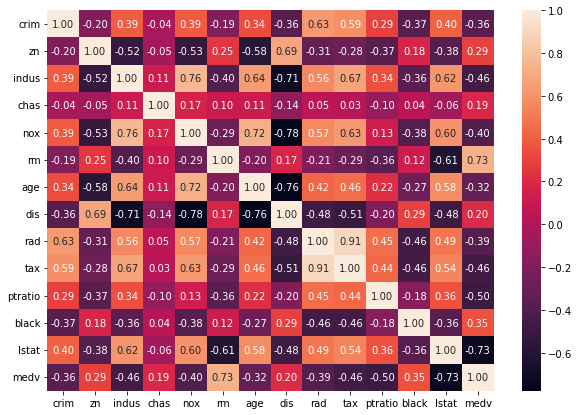

In [7]:
# Heatmap correlation
train_data = pd.concat([feature_train, target_train], axis=1)
corr = train_data.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Threshold: abs(corr) >= 0.80

Dari heatmap di atas, terlihat bahwa fitur rad dan tax memiliki korelasi positif yang sangat kuat di angka 0.91 melebihi threshold. Sehingga, kita hanya perlu mengambil salah satu dari fitur tersebut.

Fitur yang dipertahankan adalah fitur yang memiliki korelasi lebih kuat terhadap target (medv) baik berkorelasi positif atau negatif. Karena korelasi tax terhadap target (medv) lebih kuat daripada rad, maka fitur tax yang dipertahankan dan fitur rad akan didrop.

Korelasi fitur nox masih berada di dalam threshold 0.80 sehingga tidak perlu didrop.

In [8]:
# Drop redundant features
feature_train = feature_train.drop(columns=['rad'])
feature_validation = feature_validation.drop(columns=['rad'])
feature_test = feature_test.drop(columns=['rad'])

## 5. Pelatihan Model
- lambdas = [0.01, 0.1, 1, 10]
- Latih model regresi teratur (Ridge dan LASSO) pada data pelatihan dengan beberapa nilai lambda yang diberikan.
- Pilih nilai lambda terbaik dari set validasi menggunakan RMSE sebagai metrik.

### Ridge Regression

In [9]:
from sklearn.linear_model import Ridge

# Train the model
X_train = feature_train.to_numpy()
y_train = target_train.to_numpy()
y_train = y_train.reshape(len(y_train),)

# Define the ridge model
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# Fit the ridge model (training)
ridge_reg_pointzeroone.fit(X_train, y_train)
ridge_reg_pointone.fit(X_train, y_train)
ridge_reg_one.fit(X_train, y_train)
ridge_reg_ten.fit(X_train, y_train)

Ridge(alpha=10, random_state=42)

In [10]:
from sklearn.metrics import mean_squared_error

X_validation = feature_validation.to_numpy()
y_validation = target_validation.to_numpy()
y_validation = y_validation.reshape(len(target_validation),)

# Define model with various alpha value
alphas = [0.01, 0.1, 1, 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

# Find best alpha value on validation set using RMSE
for model, alpha in zip(models, alphas):
    y_predict = model.predict(X_validation)
    rmse = np.sqrt(mean_squared_error(y_validation, y_predict))
    print('RMSE of Ridge regression model with alpha = {:.2f} is {:.3f}'.format(alpha, rmse))

RMSE of Ridge regression model with alpha = 0.01 is 4.961
RMSE of Ridge regression model with alpha = 0.10 is 4.949
RMSE of Ridge regression model with alpha = 1.00 is 4.912
RMSE of Ridge regression model with alpha = 10.00 is 4.872


Model ridge regression terbaik adalah ketika nilai lambda (alpha) = 10.00 karena menghasilkan RMSE terkecil sebagai metrik evaluasi.

### LASSO Regression

In [11]:
from sklearn.linear_model import Lasso

# Train the model
X_train = feature_train.to_numpy()
y_train = target_train.to_numpy()
y_train = y_train.reshape(len(y_train),)

# Define the lasso model
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# Fit the lasso model (training)
lasso_reg_pointzeroone.fit(X_train, y_train)
lasso_reg_pointone.fit(X_train, y_train)
lasso_reg_one.fit(X_train, y_train)
lasso_reg_ten.fit(X_train, y_train)

Lasso(alpha=10, random_state=42)

In [12]:
from sklearn.metrics import mean_squared_error

X_validation = feature_validation.to_numpy()
y_validation = target_validation.to_numpy()
y_validation = y_validation.reshape(len(target_validation),)

# Define model with various alpha value
alphas = [0.01, 0.1, 1, 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

# Find best alpha value on validation set using RMSE
for model, alpha in zip(models, alphas):
    y_predict = model.predict(X_validation)
    rmse = np.sqrt(mean_squared_error(y_validation, y_predict))
    print('RMSE of Lasso regression model with alpha = {:.2f} is {:.3f}'.format(alpha, rmse))

RMSE of Lasso regression model with alpha = 0.01 is 4.934
RMSE of Lasso regression model with alpha = 0.10 is 4.907
RMSE of Lasso regression model with alpha = 1.00 is 4.846
RMSE of Lasso regression model with alpha = 10.00 is 5.427


Model Lasso regression terbaik adalah ketika nilai lambda (alpha) = 1.00 karena menghasilkan RMSE terkecil sebagai metrik evaluasi.

## 6. Interpretasi Model
- Interpretasikan sampel koefisien dari model terbaik yang dipilih.

### Ridge Regression

In [13]:
# Using best ridge model
data = feature_train
model = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,15.064666
1,crim,-0.071408
2,zn,0.033030
3,indus,-0.067858
4,chas,1.955801
5,nox,-1.568248
6,rm,4.783168
7,age,-0.011523
8,dis,-1.260056
9,tax,-0.001976


Interpretasi model ridge regression terbaik:

medv = -15.064666 - 0.071408 * crim + 0.033030 * zn - 0.067858 * indus + 1.955801 * chas - 1.568248 * nox + 4.783168 * rm - 0.011523 * age - 1.260056 * dis - 0.001976 * tax - 0.697550 * ptratio + 0.012729 * black - 0.523827 * lstat

- Setiap kenaikan satu unit pada variabel `rm` (average number of rooms per dwelling) dengan asumsi variabel lain tidak berubah, akan meningkatkan prediksi harga rumah sebesar 4.783168 unit pada target `medv`. Sehingga, semakin banyak jumlah kamar maka semakin tinggi juga harga rumah tersebut, begitupun sebaliknya.
- Setiap kenaikan satu unit pada variabel `ptratio` (pupil teacher ratio in the neighborhood) dengan asumsi variabel lain tidak berubah, akan menurunkan prediksi harga rumah sebesar 0.697550 unit pada target `medv`. Sehingga, semakin tinggi ratio siswa terhadap guru (jumlah siswa meningkat dibandingkan guru) maka semakin rendah harga rumah tersebut, begitupun sebaliknya.

### LASSO Regression

In [14]:
# Using best lasso model
data = feature_train
model = lasso_reg_one

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,25.823435
1,crim,-0.041076
2,zn,0.025273
3,indus,-0.000000
4,chas,0.000000
5,nox,-0.000000
6,rm,2.504122
7,age,0.022055
8,dis,-0.599362
9,tax,-0.002994


Interpretasi model lasso regression terbaik:

medv = -25.823435 - 0.041076 * crim + 0.025273 * zn - 0.00000 * indus + 0.000000 * chas - 0.000000 * nox + 2.504122 * rm + 0.022055 * age - 0.599362 * dis - 0.002994 * tax - 0.666222 * ptratio + 0.011400 * black - 0.712433 * lstat

- Setiap kenaikan satu unit pada variabel `rm` (average number of rooms per dwelling) dengan asumsi variabel lain tidak berubah, akan meningkatkan prediksi harga rumah sebesar 2.504122 unit pada target `medv`. Sehingga, semakin banyak jumlah kamar maka semakin tinggi juga harga rumah tersebut, begitupun sebaliknya.
- Setiap kenaikan satu unit pada variabel `ptratio` (pupil teacher ratio in the neighborhood) dengan asumsi variabel lain tidak berubah, akan menurunkan prediksi harga rumah sebesar 0.666222 unit pada target `medv`. Sehingga, semakin tinggi ratio siswa terhadap guru (jumlah siswa meningkat dibandingkan guru) maka semakin rendah harga rumah tersebut, begitupun sebaliknya.

## 7. Evaluasi Model
- Evaluasi model terbaik pada set pengujian menggunakan MAE, MAPE, dan RMSE.
- Sertakan interpretasi dari hasil evaluasi.

### Diagnostic Study (R-squared Score)

#### Ridge Regression

In [15]:
X_test = feature_test.to_numpy()
y_test = target_test.to_numpy()
y_test = y_test.reshape(len(target_test),)

from sklearn.metrics import r2_score

best_ridge_model = ridge_reg_ten

y_predict_train = best_ridge_model.predict(X_train)
print('R2 on Ridge Regression for training data is {}'.format(r2_score(y_predict_train, y_train)*100))

y_predict_test = best_ridge_model.predict(X_test)
print('R2 on Ridge Regression for test data is {}'.format(r2_score(y_predict_test, y_test)*100))

R2 on Ridge Regression for training data is 65.42246087727179
R2 on Ridge Regression for test data is 58.133002629027885


- Training Data: 65% varians pada target dijelaskan oleh semua fitur dalam model
- Test Data: 58% varians pada target dijelaskan oleh semua fitur dalam model
- Model termasuk dalam underfitting karena Training data dan Test data memiliki R^2 score di bawah 70%

#### LASSO Regression

In [16]:
X_test = feature_test.to_numpy()
y_test = target_test.to_numpy()
y_test = y_test.reshape(len(target_test),)

from sklearn.metrics import r2_score

best_lasso_model = lasso_reg_one

y_predict_train = best_lasso_model.predict(X_train)
print('R2 on Lasso Regression for training data is {}'.format(r2_score(y_predict_train, y_train)*100))

y_predict_test = best_lasso_model.predict(X_test)
print('R2 on Lasso Regression for test data is {}'.format(r2_score(y_predict_test, y_test)*100))

R2 on Lasso Regression for training data is 51.33022055846548
R2 on Lasso Regression for test data is 50.88700595145043


- Training Data: 51% varians pada target dijelaskan oleh semua fitur dalam model
- Test Data: 50% varians pada target dijelaskan oleh semua fitur dalam model
- Model termasuk dalam underfitting karena Training data dan Test data memiliki R^2 score di bawah 70%

### Training Error

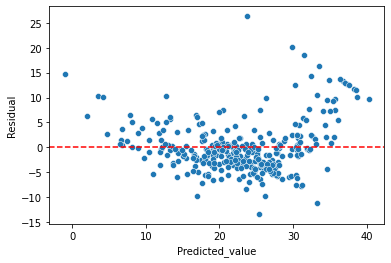

In [17]:
# Calculate Residuals
residual = y_train - y_predict_train

# Create DataFrame
df_res = pd.DataFrame({
    'Predicted_value': y_predict_train,
    'Residual': residual
})

# Residual Plot
sns.scatterplot(data=df_res, x='Predicted_value', y='Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Residual memiliki varians yang cukup tersebar. Sehingga, dapat disimpulkan bahwa tidak terdapat bias pada residual.

### Testing Error

#### Ridge Regression

In [18]:
y_predict_test = best_ridge_model.predict(X_test)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('MAE for testing data is {}'.format(mean_absolute_error(y_predict_test, y_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_predict_test, y_test)))
print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_predict_test, y_test))))

# # Melihat rata-rata dan median target 'medv'
# df['medv'].describe()
# # Output: mean -> 22.5; median -> 21.2

MAE for testing data is 3.244481645704498
MAPE for testing data is 0.2622349874986085
RMSE for testing data is 5.158908333657056


Interpretasi untuk testing data:
- Berdasarkan hasil MAE, ada deviasi/error antara nilai prediksi dan nilai nyata adalah sebesar 3.244 poin. Jika dibandingkan dengan rata-rata dan median `medv` di sekitar 20 poin, maka deviasi sebesar 3.244 poin termasuk deviasi yang kecil.
- Berdasarkan hasil MAPE, deviasi sebesar 3.244 poin setara dengan deviasi sebesar 26.223% terhadap nilai nyata `medv`. Model ini memiliki deviasi yang cukup besar tetapi jika menggunakan batas 30% untuk menentukan apakah model masih dapat diterima atau tidak, maka model masih dapat diterima untuk memprediksi nilai `medv`.
- Berdasarkan hasil RMSE, ternyata nilai RMSE lebih besar daripada nilai MAE. Hal ini menunjukkan bahwa ada outlier prediksi.

#### LASSO Regression

In [19]:
y_predict_test = best_lasso_model.predict(X_test)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('MAE for testing data is {}'.format(mean_absolute_error(y_predict_test, y_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_predict_test, y_test)))
print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_predict_test, y_test))))

# # Melihat rata-rata dan median target 'medv'
# df['medv'].describe()
# # Output: mean -> 22.5; median -> 21.2

MAE for testing data is 3.3980507105960682
MAPE for testing data is 0.2950524268933147
RMSE for testing data is 5.125494212319777


Interpretasi untuk testing data:
- Berdasarkan hasil MAE, ada deviasi/error antara nilai prediksi dan nilai nyata adalah sebesar 3.398 poin. Jika dibandingkan dengan rata-rata dan median `medv` di sekitar 20 poin, maka deviasi sebesar 3.398 poin termasuk deviasi yang kecil.
- Berdasarkan hasil MAPE, deviasi sebesar 3.398 poin setara dengan deviasi sebesar 29.505% terhadap nilai nyata `medv`. Model ini memiliki deviasi yang cukup besar tetapi jika menggunakan batas 30% untuk menentukan apakah model masih dapat diterima atau tidak, maka model masih dapat diterima untuk memprediksi nilai `medv`.
- Berdasarkan hasil RMSE, ternyata nilai RMSE lebih besar daripada nilai MAE. Hal ini menunjukkan bahwa ada outlier prediksi.

Interpretasi antara Ridge dan Lasso:

- Bila hasil error antara model Ridge dan model Lasso dibandingkan, model Ridge memiliki MAPE (persentase error) yang lebih kecil daripada model Lasso yang artinya model Ridge lebih baik/akurat daripada model Lasso.
- Model Ridge juga memiliki R^2 Score yang lebih baik dibandingkan dengan model Lasso meskipun keduanya tergolong model yang underfitting. Sehingga, model Ridge dinilai sedikit lebih baik daripada model Lasso pada kasus ini.